In [1]:
from pygrounds.utils import S3Utils, DSWarehouse
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate

In [3]:
query = \
"""
  SELECT
DISTINCT merged_eligibility.gr_lookup_id AS pid,
         2020 - year_of_birth AS age
    FROM `grnds-frankie.covid_guidance_engine.amazon__worksite_eligiblity` AS worksite_eligibility
    JOIN `national-claims-warehouse.bronze.merged_eligibility` AS merged_eligibility
      ON worksite_eligibility.gr_lookup_id = merged_eligibility.gr_lookup_id
   WHERE merged_eligibility.gr_lookup_id_type = 'pid'
"""

In [4]:
dsw = DSWarehouse()
age_distribution = dsw.query_to_df(query)

In [5]:
age_distribution.to_csv('amazon_age_distribution.csv')

### Note: switch to pyseir env before running following codes.

In [1]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
import numpy as np
import dill as pickle
from pyseir.inference import model_fitter
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
from pyseir import load_data
#from pyseir.inference.whitelist_generator import WhitelistGenerator
from pyseir.utils import get_run_artifact_path, RunArtifact
#from pyseir.ensembles.ensemble_runner import EnsembleRunner
from pyseir.utils import get_run_artifact_path, RunArtifact, RunMode
from pyseir.deployment.demographic_mapper import DemographicMapper, CovidMeasure

In [2]:
def load_inference_results(fips):
    """
    This function will be added to pyseir soon. 
    """
    model_path = get_run_artifact_path(fips, RunArtifact.MLE_FIT_MODEL)
    model = pickle.loads(open(model_path, 'rb').read())

    fit_results_path = get_run_artifact_path(fips, RunArtifact.MLE_FIT_RESULT)
    with open(fit_results_path) as f:
        fit_results = json.load(f)
    fit_results = pd.DataFrame(fit_results).set_index('fips').loc[fips].to_dict()
    return model, fit_results

#### Run inference for CA

In [ ]:
model_fitter.run_state(state='California', states_only=True, with_age_structure=True)

In [4]:
# get target age distribution pdf
age_distribution = pd.read_csv('amazon_age_distribution.csv')
age_counts = age_distribution.age.value_counts().sort_index() \
                    .rename('count') \
                    .reset_index().rename(columns={'index': 'age'})
age_counts['pmf'] = age_counts['count'] / age_counts['count'].sum()
age_distribution = scipy.interpolate.interp1d(np.append(age_counts['age'], 120), 
                                              np.append(age_counts['pmf'], 0))

In [5]:
measure_units = ['per_capita', 'per_capita_day']
measures = ['IHR', 'IHR_icu', 'IFR']

In [18]:
for fips in ['06']:
    model_path = get_run_artifact_path(fips, RunArtifact.MLE_FIT_MODEL)
    model = pickle.loads(open(model_path,'rb').read())

    fit_results_path = get_run_artifact_path(fips, RunArtifact.MLE_FIT_RESULT)
    with open(fit_results_path) as f:
        fit_results = json.load(f)
    fit_results = pd.DataFrame(fit_results).set_index('fips').loc[fips].to_dict()

    dm = DemographicMapper(fips=fips,
                      mle_model=model,
                      fit_results=fit_results,
                      measure_units=measure_units,
                      measures=measures,
                      target_age_distribution_pdf = age_distribution)
    results = dm.run()

R (366, 16)
incident_I (366, 16)
S (366, 16)
E (366, 16)
A (366, 16)
I (366, 16)
HGen (366, 16)
HICU (366, 16)
HVent (366, 16)
N (366, 16)


/Users/xzhang/Documents/covid/covid-data-model/pyseir/deployment/demographic_mapper.py:256: RuntimeWarning: divide by zero encountered in true_divide
  ) / self.predictions["HICU"]
/Users/xzhang/Documents/covid/covid-data-model/pyseir/deployment/demographic_mapper.py:275: RuntimeWarning: divide by zero encountered in true_divide
  ) / self.predictions["HGen"]


In [29]:
with open('demo_mapper_output.pkl', 'wb') as file:
    pickle.dump(results, file)

In [19]:
results

defaultdict(dict,
            {'compartments':                        R   incident_I             S             E    A  \
             2020-02-26  3.408791e+00     4.090550  3.858029e+07     20.354213  0.0   
             2020-02-27  7.911261e+00     5.257621  3.858897e+07     26.161459  0.0   
             2020-02-28  1.381185e+01     6.836161  3.859765e+07     34.016135  0.0   
             2020-02-29  2.153119e+01     8.934224  3.860632e+07     44.455908  0.0   
             2020-03-01  3.162650e+01    11.702540  3.861498e+07     58.230804  0.0   
             ...                  ...          ...           ...           ...  ...   
             2021-02-21  6.082899e+06  3068.804125  3.552764e+07  15270.098071  0.0   
             2021-02-22  6.089302e+06  3054.282832  3.553003e+07  15197.841402  0.0   
             2021-02-23  6.095649e+06  3037.109210  3.553247e+07  15112.386978  0.0   
             2021-02-24  6.101948e+06  3013.602906  3.553497e+07  14995.421689  0.0   
         

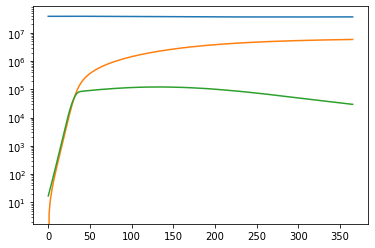

In [25]:
plt.plot(model.t_list, model.results['S'])
plt.plot(model.t_list, model.results['R'])
plt.plot(model.t_list, model.results['I'])
plt.yscale('log')

In [28]:
results['compartments'].columns

Index(['R', 'incident_I', 'S', 'E', 'A', 'I', 'HGen', 'HICU', 'HVent', 'N'], dtype='object')

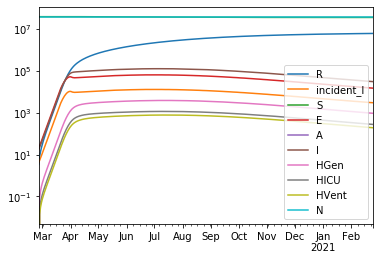

In [20]:
results['compartments'].plot()
plt.yscale('log')

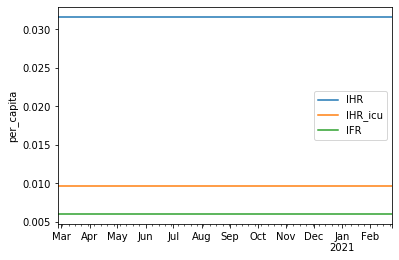

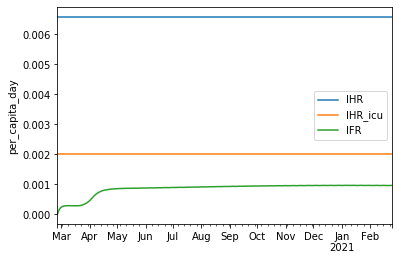

In [21]:
for unit in measure_units:
    plt.figure()
    for measure in measures:
        results[measure][unit].plot(label=measure)
    plt.ylabel(unit)
    plt.legend()

In [6]:
from pyseir.inference.infer_rt import run_state as run_rt_infer
run_rt_infer(state='California', states_only=True)

/Users/xzhang/Documents/covid/covid-data-model/pyseir/inference/infer_rt.py:466: RuntimeWarning: Mean of empty slice
  df_all[["Rt_MAP__new_cases", "Rt_MAP__new_deaths"]], axis=1
